# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

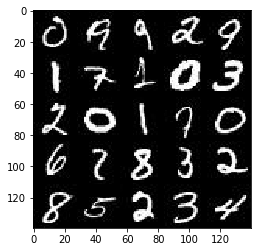

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

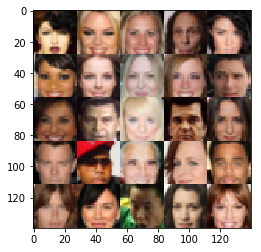

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return \
        tf.placeholder(
            tf.float32,
            shape=[None, image_width, image_height,
                   image_channels],
            name='image_input'
        ),\
        tf.placeholder(
            tf.float32,
            shape=[None, z_dim],
            name='input_z'
        ),\
        tf.placeholder(
            tf.float32,
            name='learning_rate'
        )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [91]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)

        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [87]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
            x1 = tf.layers.dense(z, 7*7*128)
            
            x1 = tf.reshape(x1, (-1, 7, 7, 128))
            x1 = tf.layers.batch_normalization(x1, training=is_train)
            x1 = tf.maximum(alpha * x1, x1)

            x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides=2, padding='same')
            x2 = tf.layers.batch_normalization(x2, training=is_train)
            x2 = tf.maximum(alpha * x2, x2)

            logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')

            out = tf.tanh(logits)

            return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [92]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_2 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_1 + d_loss_2
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [93]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    vars = tf.trainable_variables()
    d_vars = [var for var in vars if var.name.startswith('discriminator')]
    g_vars = [var for var in vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        return \
            tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars),\
            tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [94]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [96]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    img_w, img_h, img_chan = data_shape[1], data_shape[2], data_shape[3]
    inp_real, inp_z, _ = model_inputs(img_w, img_h, img_chan, z_dim)
    d_loss, g_loss = model_loss(inp_real, inp_z, img_chan)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    
    display_interval = 100
    num_img_to_disp = 25
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2
                #Random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #Run optimizers
                _ = sess.run(d_opt, feed_dict={inp_real: batch_images, inp_z: batch_z})
                _ = sess.run(g_opt, feed_dict={inp_z: batch_z, inp_real: batch_images})
                
                if steps % display_interval == 0:
                    train_loss_d = d_loss.eval({inp_real: batch_images, inp_z: batch_z})
                    train_loss_g = g_loss.eval({inp_z: batch_z})
                    
                    print("Epoch: {} of {}".format(epoch_i, epoch_count),
                          "D-loss: {}".format(train_loss_d),
                          "G-loss: {}".format(train_loss_g))
                    
                    show_generator_output(sess, num_img_to_disp, inp_z, img_chan, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 0 of 2 D-loss: 0.5391666889190674 G-loss: 2.2995431423187256


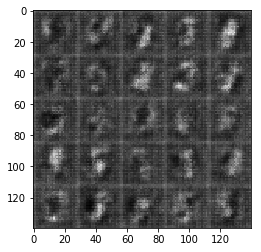

Epoch: 0 of 2 D-loss: 0.8975945115089417 G-loss: 2.3413166999816895


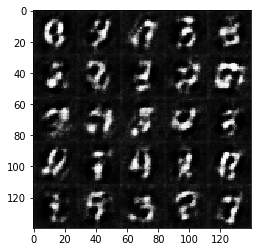

Epoch: 0 of 2 D-loss: 0.79310142993927 G-loss: 0.9347778558731079


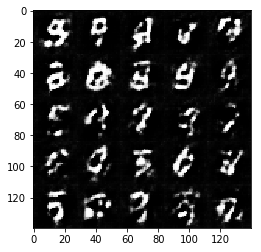

Epoch: 0 of 2 D-loss: 0.7135664224624634 G-loss: 1.1123948097229004


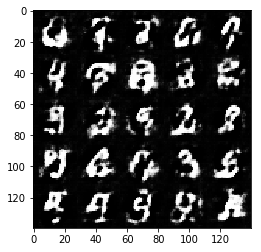

Epoch: 0 of 2 D-loss: 0.5682525634765625 G-loss: 1.508472204208374


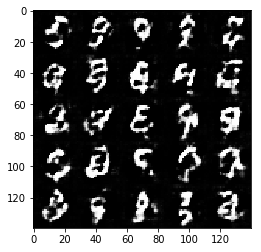

Epoch: 0 of 2 D-loss: 0.636867105960846 G-loss: 1.2927882671356201


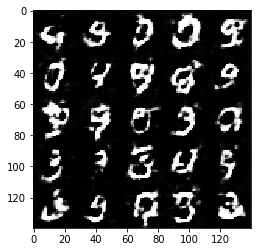

Epoch: 0 of 2 D-loss: 0.45319128036499023 G-loss: 1.379237174987793


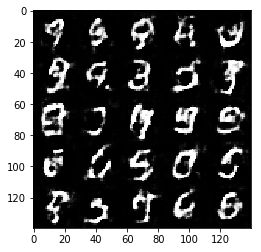

Epoch: 0 of 2 D-loss: 0.4897364675998688 G-loss: 1.672921061515808


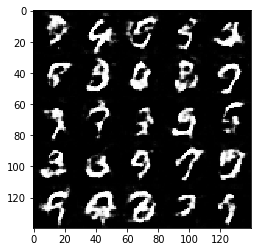

Epoch: 0 of 2 D-loss: 0.552374005317688 G-loss: 1.2338409423828125


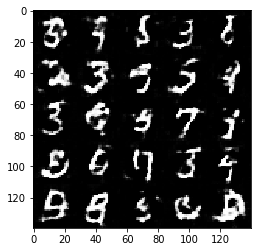

Epoch: 0 of 2 D-loss: 0.6954278945922852 G-loss: 1.5751302242279053


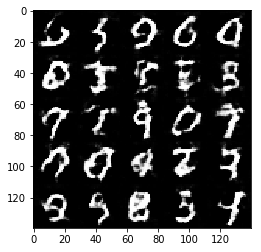

Epoch: 0 of 2 D-loss: 0.6138781905174255 G-loss: 1.8759486675262451


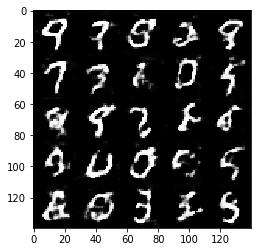

Epoch: 0 of 2 D-loss: 0.7150304317474365 G-loss: 0.9466752409934998


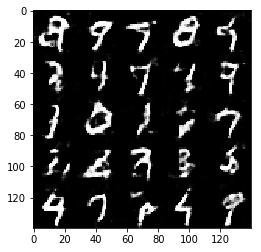

Epoch: 0 of 2 D-loss: 0.6092244386672974 G-loss: 1.4878273010253906


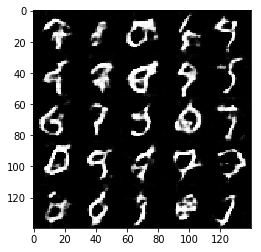

Epoch: 0 of 2 D-loss: 0.5053708553314209 G-loss: 1.7177186012268066


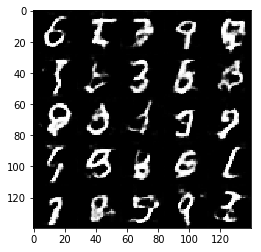

Epoch: 0 of 2 D-loss: 0.6398372650146484 G-loss: 1.2910242080688477


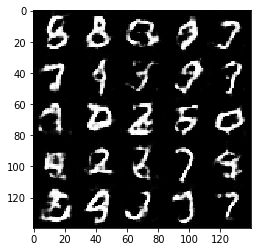

Epoch: 0 of 2 D-loss: 0.6557894945144653 G-loss: 1.3456922769546509


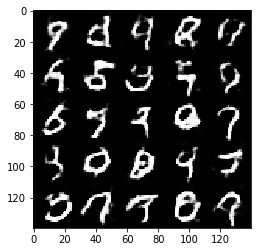

Epoch: 0 of 2 D-loss: 0.8472046256065369 G-loss: 0.78510981798172


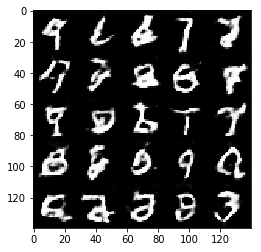

Epoch: 0 of 2 D-loss: 0.773600697517395 G-loss: 1.146639347076416


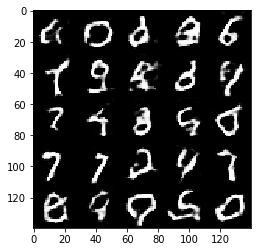

Epoch: 1 of 2 D-loss: 0.9723601341247559 G-loss: 0.6803014278411865


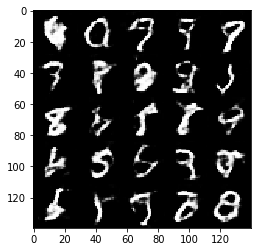

Epoch: 1 of 2 D-loss: 0.5887997150421143 G-loss: 1.52005934715271


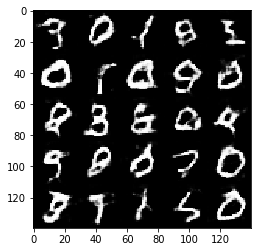

Epoch: 1 of 2 D-loss: 0.8241585493087769 G-loss: 0.775072455406189


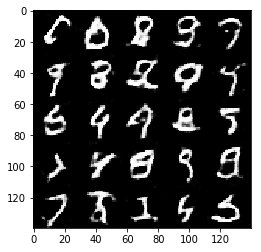

Epoch: 1 of 2 D-loss: 0.6048212051391602 G-loss: 1.161989450454712


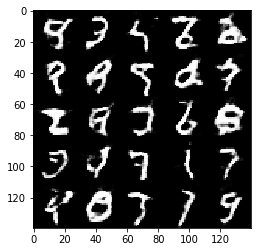

Epoch: 1 of 2 D-loss: 0.39913737773895264 G-loss: 1.7696142196655273


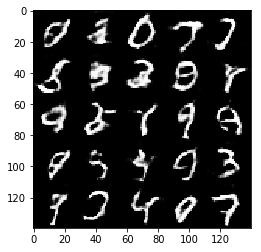

Epoch: 1 of 2 D-loss: 0.5921352505683899 G-loss: 1.1431738138198853


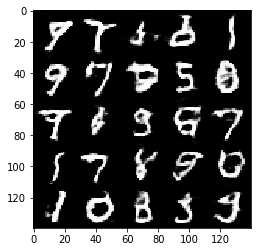

Epoch: 1 of 2 D-loss: 0.5210222005844116 G-loss: 1.5016050338745117


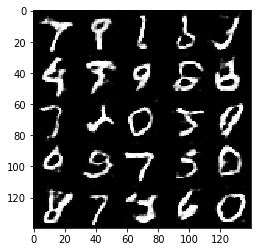

Epoch: 1 of 2 D-loss: 0.45597726106643677 G-loss: 1.3791396617889404


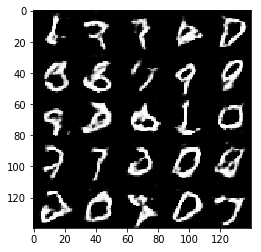

Epoch: 1 of 2 D-loss: 0.4665980637073517 G-loss: 1.5218806266784668


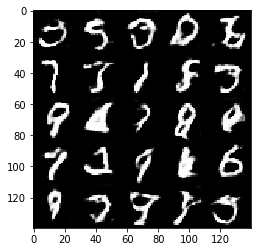

Epoch: 1 of 2 D-loss: 0.47122734785079956 G-loss: 1.881813645362854


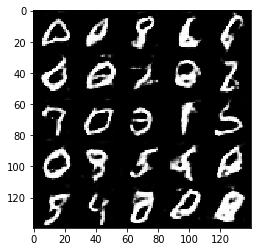

Epoch: 1 of 2 D-loss: 0.6035251021385193 G-loss: 1.0731401443481445


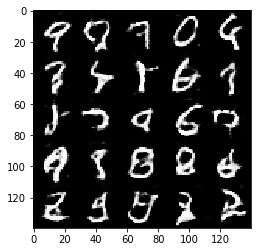

Epoch: 1 of 2 D-loss: 1.4398378133773804 G-loss: 0.4285445809364319


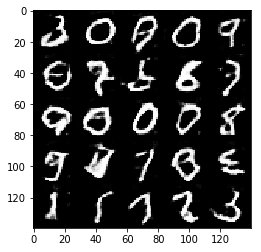

Epoch: 1 of 2 D-loss: 0.45568037033081055 G-loss: 1.4802706241607666


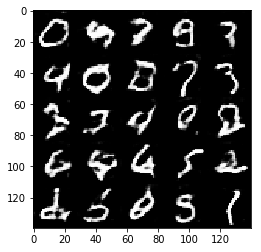

Epoch: 1 of 2 D-loss: 0.4823797047138214 G-loss: 1.4131443500518799


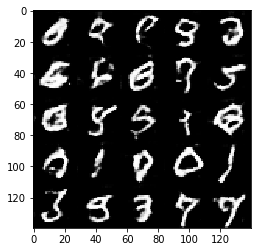

Epoch: 1 of 2 D-loss: 0.4452733099460602 G-loss: 1.4764553308486938


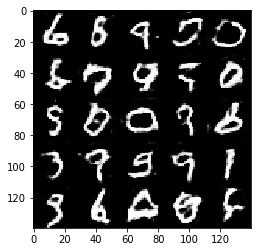

Epoch: 1 of 2 D-loss: 0.3920961618423462 G-loss: 1.6155827045440674


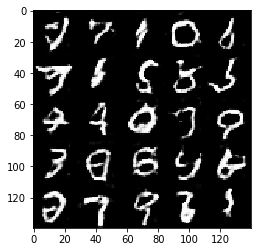

Epoch: 1 of 2 D-loss: 0.29618048667907715 G-loss: 1.9856724739074707


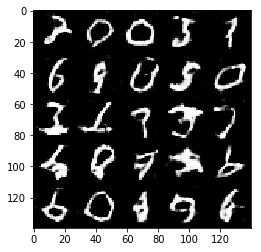

Epoch: 1 of 2 D-loss: 0.38263630867004395 G-loss: 1.7254571914672852


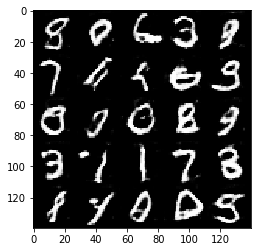

Epoch: 1 of 2 D-loss: 0.5627943277359009 G-loss: 1.1765414476394653


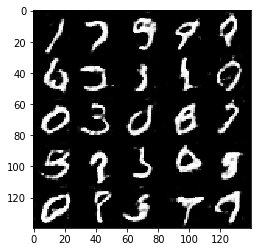

In [97]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 0 of 1 D-loss: 0.6513157486915588 G-loss: 1.0827913284301758


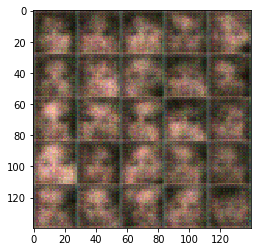

Epoch: 0 of 1 D-loss: 0.8430140018463135 G-loss: 1.9411882162094116


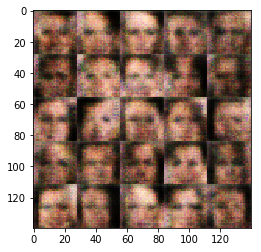

Epoch: 0 of 1 D-loss: 1.1691391468048096 G-loss: 0.5131836533546448


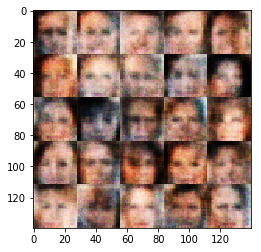

Epoch: 0 of 1 D-loss: 0.934013307094574 G-loss: 0.812045693397522


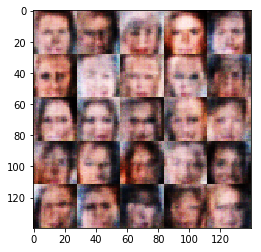

Epoch: 0 of 1 D-loss: 0.8830019235610962 G-loss: 0.8348852396011353


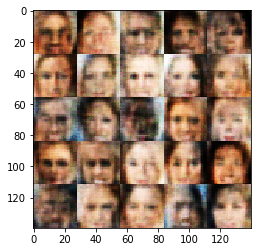

Epoch: 0 of 1 D-loss: 0.8264487981796265 G-loss: 1.08010733127594


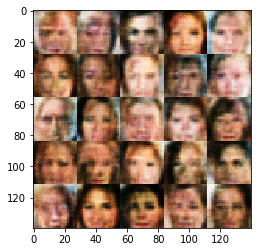

Epoch: 0 of 1 D-loss: 0.7362344264984131 G-loss: 1.190969467163086


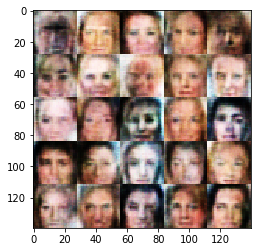

Epoch: 0 of 1 D-loss: 0.8754218816757202 G-loss: 1.0193406343460083


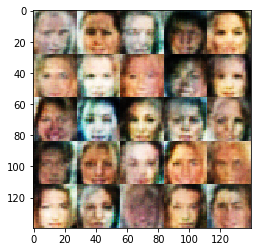

Epoch: 0 of 1 D-loss: 1.1126590967178345 G-loss: 0.9247655868530273


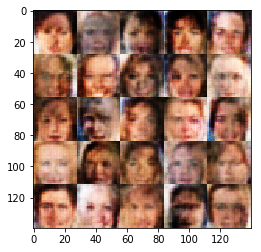

Epoch: 0 of 1 D-loss: 0.9276143312454224 G-loss: 1.3139328956604004


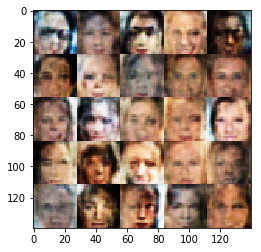

Epoch: 0 of 1 D-loss: 1.2428724765777588 G-loss: 0.7951692342758179


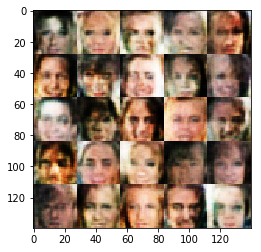

Epoch: 0 of 1 D-loss: 1.2566879987716675 G-loss: 0.6814365386962891


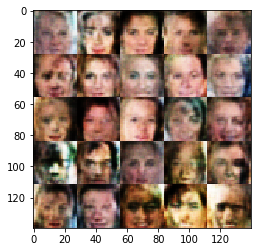

Epoch: 0 of 1 D-loss: 1.2261936664581299 G-loss: 0.8667938709259033


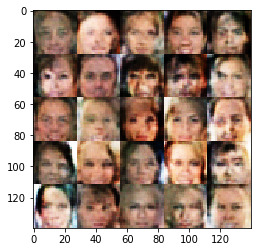

Epoch: 0 of 1 D-loss: 1.0598721504211426 G-loss: 0.7771056294441223


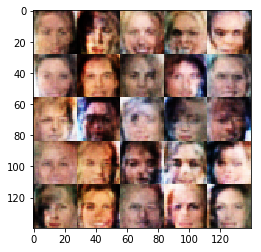

Epoch: 0 of 1 D-loss: 1.0924100875854492 G-loss: 1.115079402923584


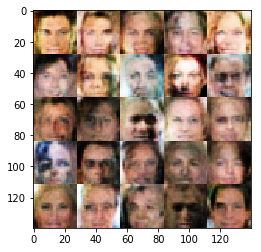

Epoch: 0 of 1 D-loss: 1.1327793598175049 G-loss: 1.3616981506347656


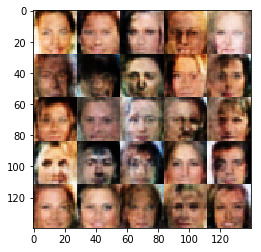

Epoch: 0 of 1 D-loss: 0.9261082410812378 G-loss: 1.0280685424804688


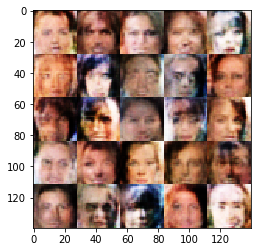

Epoch: 0 of 1 D-loss: 1.1427282094955444 G-loss: 1.2109477519989014


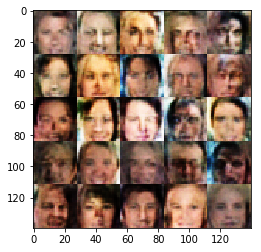

Epoch: 0 of 1 D-loss: 1.128495454788208 G-loss: 0.77203369140625


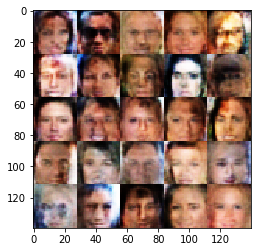

Epoch: 0 of 1 D-loss: 1.123119831085205 G-loss: 0.6245384216308594


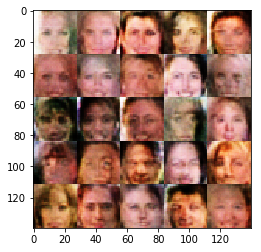

Epoch: 0 of 1 D-loss: 0.7260092496871948 G-loss: 1.1493499279022217


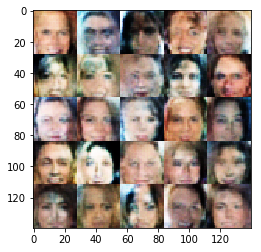

Epoch: 0 of 1 D-loss: 1.1739284992218018 G-loss: 0.6047641038894653


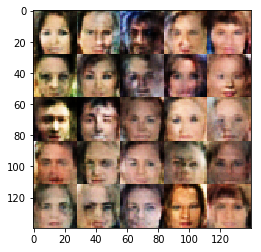

Epoch: 0 of 1 D-loss: 0.8976516127586365 G-loss: 1.2201296091079712


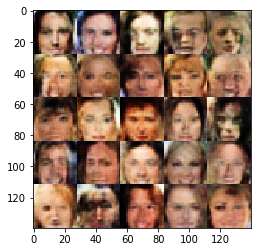

Epoch: 0 of 1 D-loss: 1.0594329833984375 G-loss: 0.8659907579421997


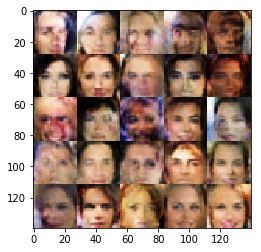

Epoch: 0 of 1 D-loss: 1.1041247844696045 G-loss: 1.0080926418304443


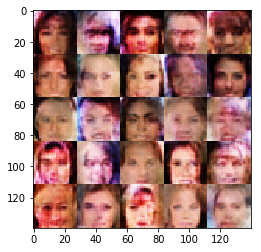

Epoch: 0 of 1 D-loss: 0.9995476007461548 G-loss: 0.8901782035827637


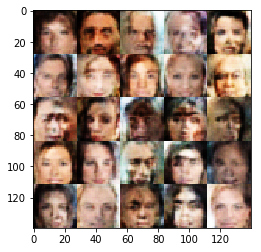

Epoch: 0 of 1 D-loss: 0.8298320174217224 G-loss: 0.9991481900215149


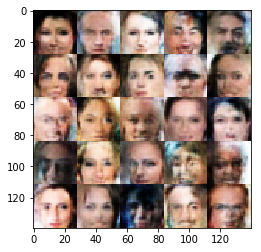

Epoch: 0 of 1 D-loss: 1.028315782546997 G-loss: 1.2466669082641602


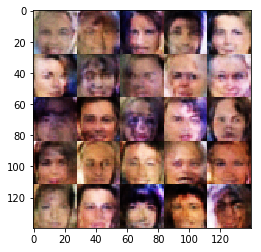

Epoch: 0 of 1 D-loss: 1.0740729570388794 G-loss: 0.8256305456161499


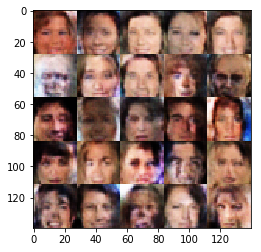

Epoch: 0 of 1 D-loss: 1.0063849687576294 G-loss: 0.8026559352874756


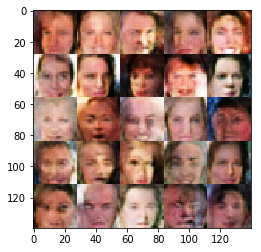

Epoch: 0 of 1 D-loss: 1.2438546419143677 G-loss: 0.6040338277816772


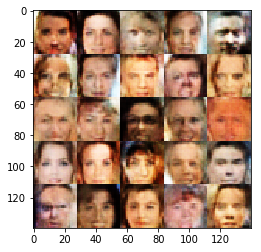

Epoch: 0 of 1 D-loss: 0.9579379558563232 G-loss: 0.9337537288665771


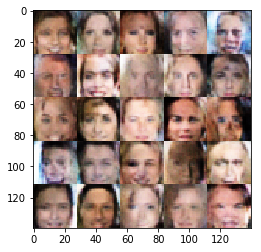

Epoch: 0 of 1 D-loss: 0.9736708402633667 G-loss: 0.9194068908691406


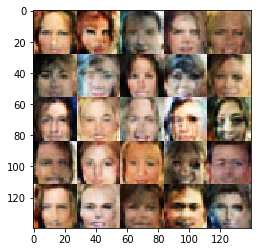

Epoch: 0 of 1 D-loss: 0.933546781539917 G-loss: 0.8367288112640381


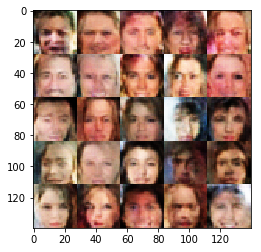

Epoch: 0 of 1 D-loss: 1.2816803455352783 G-loss: 0.5954708456993103


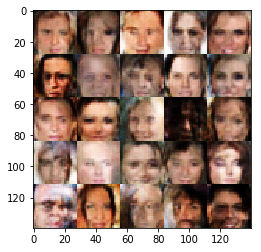

Epoch: 0 of 1 D-loss: 1.1527736186981201 G-loss: 0.703919529914856


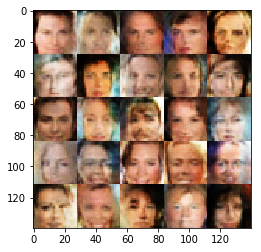

Epoch: 0 of 1 D-loss: 0.9050215482711792 G-loss: 0.7327181696891785


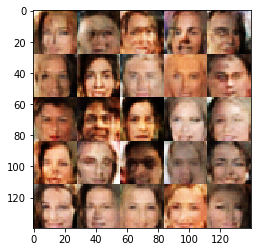

Epoch: 0 of 1 D-loss: 1.015741229057312 G-loss: 1.0292859077453613


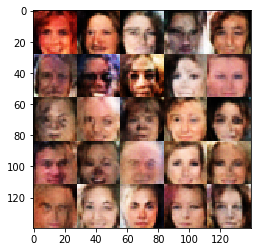

Epoch: 0 of 1 D-loss: 1.123008370399475 G-loss: 0.8050357103347778


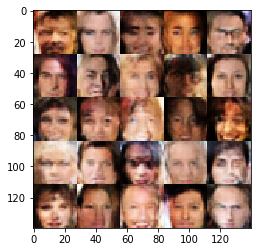

Epoch: 0 of 1 D-loss: 0.9167011976242065 G-loss: 1.0790865421295166


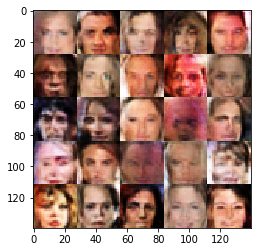

Epoch: 0 of 1 D-loss: 1.0033721923828125 G-loss: 0.9385285377502441


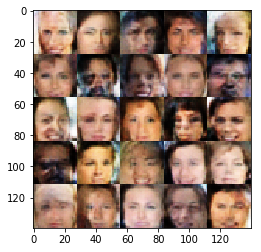

Epoch: 0 of 1 D-loss: 0.947760820388794 G-loss: 0.9321793913841248


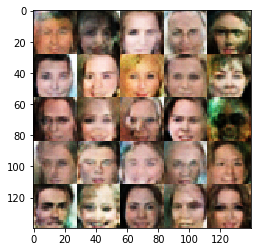

Epoch: 0 of 1 D-loss: 0.9700342416763306 G-loss: 0.7347567081451416


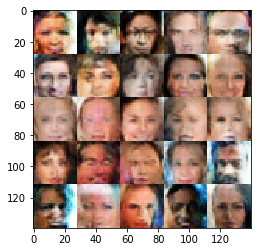

Epoch: 0 of 1 D-loss: 1.1637884378433228 G-loss: 0.9156661629676819


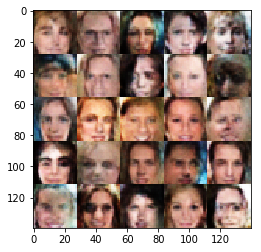

Epoch: 0 of 1 D-loss: 1.2217769622802734 G-loss: 0.7443035840988159


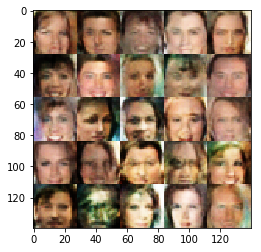

Epoch: 0 of 1 D-loss: 1.3894157409667969 G-loss: 0.43433892726898193


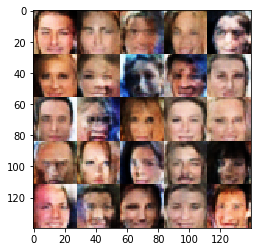

Epoch: 0 of 1 D-loss: 1.0298635959625244 G-loss: 0.9460082054138184


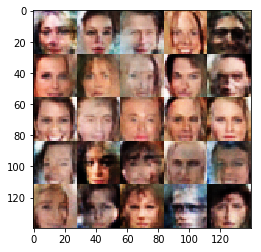

Epoch: 0 of 1 D-loss: 1.0144981145858765 G-loss: 0.8054088950157166


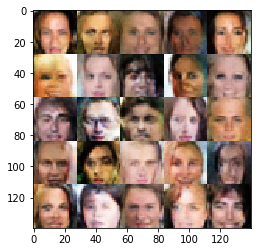

Epoch: 0 of 1 D-loss: 1.0015231370925903 G-loss: 0.9238856434822083


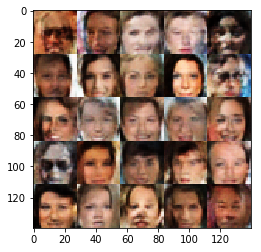

Epoch: 0 of 1 D-loss: 0.8267247676849365 G-loss: 1.0661598443984985


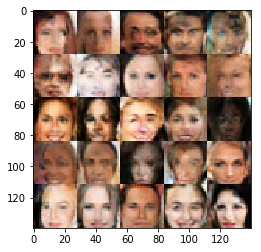

Epoch: 0 of 1 D-loss: 1.1381038427352905 G-loss: 0.68479984998703


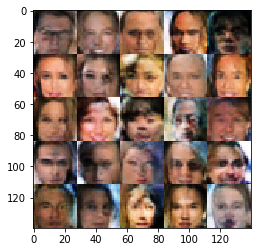

Epoch: 0 of 1 D-loss: 0.7641849517822266 G-loss: 1.1946102380752563


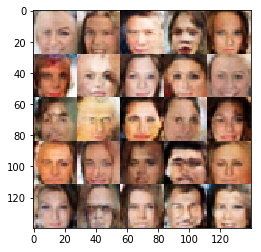

Epoch: 0 of 1 D-loss: 1.1016387939453125 G-loss: 0.9396533370018005


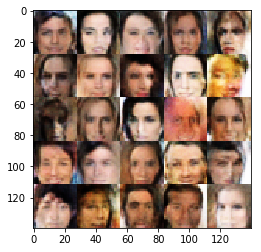

Epoch: 0 of 1 D-loss: 1.1475898027420044 G-loss: 0.6937500238418579


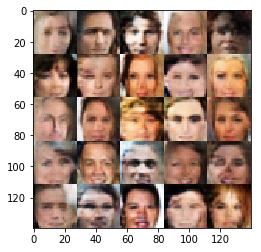

Epoch: 0 of 1 D-loss: 1.0672639608383179 G-loss: 1.1297001838684082


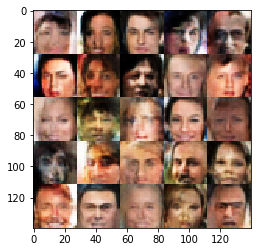

Epoch: 0 of 1 D-loss: 1.292569637298584 G-loss: 0.5260360240936279


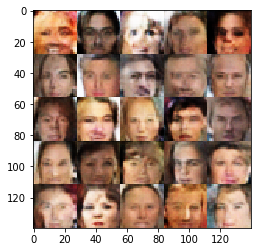

Epoch: 0 of 1 D-loss: 1.042792797088623 G-loss: 0.9523698687553406


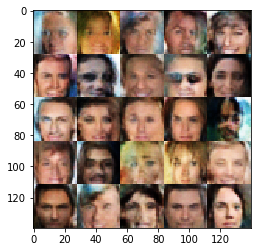

Epoch: 0 of 1 D-loss: 1.090966820716858 G-loss: 0.884600818157196


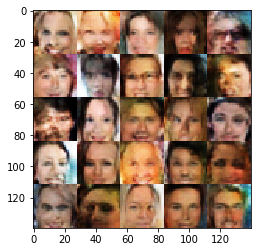

Epoch: 0 of 1 D-loss: 1.080143928527832 G-loss: 0.7268129587173462


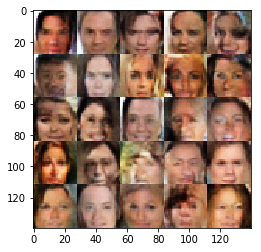

Epoch: 0 of 1 D-loss: 0.9098325371742249 G-loss: 0.9007792472839355


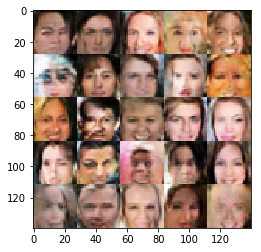

Epoch: 0 of 1 D-loss: 0.9275919795036316 G-loss: 0.8014258146286011


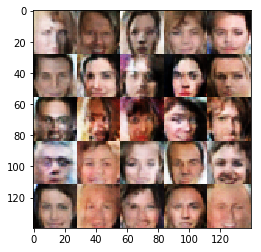

Epoch: 0 of 1 D-loss: 0.9633482694625854 G-loss: 1.2000353336334229


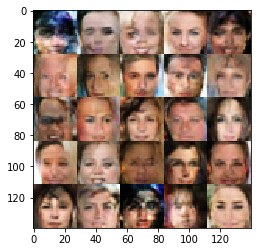

Epoch: 0 of 1 D-loss: 1.0474934577941895 G-loss: 0.8776285648345947


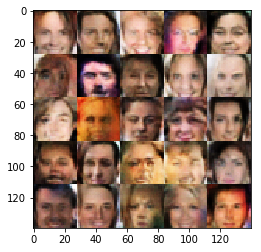

In [98]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.